# CarND P5: Vehicle Detection

In [282]:
import cv2
import time
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

## Dataset Exploration

Vehicle Images in Dataset: 8792
Non-vehicle Images in Dataset: 8968


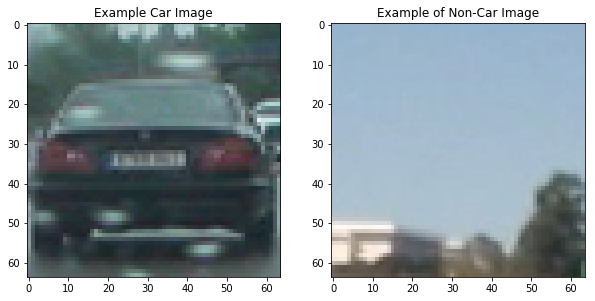

In [283]:
import os
import glob

# Load vehicle images 
basedir = 'vehicles/vehicles/'
image_types = os.listdir(basedir)
cars = []
for imtype in image_types:
    cars.extend(glob.glob('{}/{}/*'.format(basedir, imtype)))
                
print('Vehicle Images in Dataset: {}'.format(len(cars)))

# Repeat for non-vehicles
basedir = 'non-vehicles/non-vehicles/'
image_types = os.listdir(basedir)
non_cars = []
for imtype in image_types:
    non_cars.extend(glob.glob('{}/{}/*'.format(basedir, imtype)))
                
print('Non-vehicle Images in Dataset: {}'.format(len(non_cars)))

car_img = cv2.imread(cars[0])
car_img = cv2.cvtColor(car_img, cv2.COLOR_BGR2RGB)

non_car_img = cv2.imread(non_cars[1])
non_car_img = cv2.cvtColor(non_car_img, cv2.COLOR_BGR2RGB)

# Plot the examples
fig = plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(car_img)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(non_car_img)
plt.title('Example of Non-Car Image')


### Exploring HOG Features

In [284]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                              cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                              visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                   cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                   visualise=vis, feature_vector=feature_vec)
        return features


def bin_spatial(img, color_space='RGB', size=(32, 32)):
     # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_img = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: 
        feature_img = np.copy(img)
    features = cv2.resize(feature_img, size).ravel()
    return features
    

def color_hist(img, nbins=32, vis=False):
    rhist = np.histogram(img[:,:,0], bins=nbins)
    ghist = np.histogram(img[:,:,1], bins=nbins)
    bhist = np.histogram(img[:,:,2], bins=nbins)
    # Concat features
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    if vis:
    # Generate bin centers
        bin_edges = rhist[1]
        bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
        return rhist, ghist, bhist, bin_centers, hist_features
    return hist_features


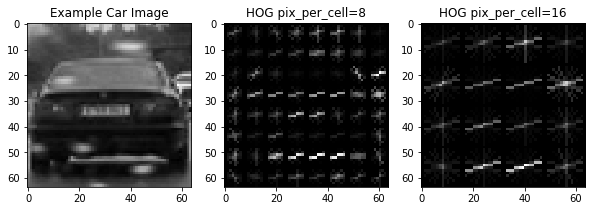

In [280]:
img = cv2.imread(cars[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

pix_per_cell = 8
cell_per_block = 2
orient = 9
features, hog_img_8 = get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)


pix_per_cell = 16
cell_per_block = 2
orient = 9
features, hog_img_16 = get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)



# Plot the examples
fig = plt.figure(figsize=(10,10))
plt.subplot(131)
plt.imshow(img, cmap='gray')
plt.title('Example Car Image')
plt.subplot(132)
plt.imshow(hog_img_8, cmap='gray')
plt.title('HOG pix_per_cell=8')
plt.subplot(133)
plt.imshow(hog_img_16, cmap='gray')
plt.title('HOG pix_per_cell=16')


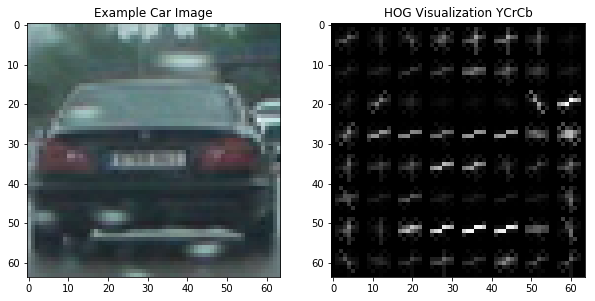

In [285]:
img = cv2.imread(cars[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_ycrcb = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)

pix_per_cell = 8
cell_per_block = 2
orient = 9
features, hog_img = get_hog_features(img_ycrcb[:,:,0], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)

# Plot the examples
fig = plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_img, cmap='gray')
plt.title('HOG Visualization YCrCb')

The following cell visualizes a non-car image HOG features.

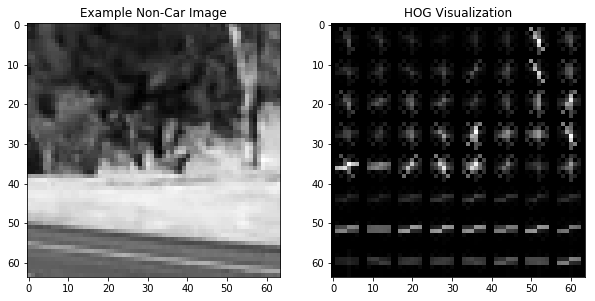

In [286]:
img = cv2.imread(non_cars[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

pix_per_cell = 8
cell_per_block = 2
orient = 9
features, hog_img = get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)

# Plot the examples
fig = plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.title('Example Non-Car Image')
plt.subplot(122)
plt.imshow(hog_img, cmap='gray')
plt.title('HOG Visualization')

### Histograms of Color and Spatial Binning

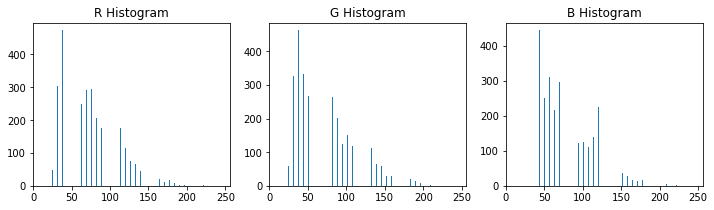

In [287]:
img = cv2.imread(cars[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

rhist, ghist, bhist, bin_centers, hist_features = color_hist(img, nbins=32, vis=True)

# Plot a figure with all three bar charts
fig = plt.figure(figsize=(12,3))
plt.subplot(131)
plt.bar(bin_centers, rhist[0])
plt.xlim(0, 256)
plt.title('R Histogram')
plt.subplot(132)
plt.bar(bin_centers, ghist[0])
plt.xlim(0, 256)
plt.title('G Histogram')
plt.subplot(133)
plt.bar(bin_centers, bhist[0])
plt.xlim(0, 256)
plt.title('B Histogram')

In [288]:
img = cv2.imread(cars[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
feature_vec = bin_spatial(img, color_space='RGB', size=(32, 32))

print(feature_vec.shape)

(3072,)


## Color Classify

We can test the performance of a classifier using only histograms of color and spatial binning.

In [289]:
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256)):
    features = []
    for fname in imgs:
        img = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)
        feature_img = np.copy(img)
        # Get spatial color features
        spatial_features = bin_spatial(feature_img, size=spatial_size)
        # Get histogram
        hist_features = color_hist(feature_img, nbins=hist_bins)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))
        
    return features



# Get features for cars and non-cars
car_features = extract_features(cars, cspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256))
noncar_features = extract_features(non_cars, cspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256))

# Create feature vectors
y = np.hstack((np.ones(len(car_features)), np.zeros(len(noncar_features))))
X = np.vstack((car_features, noncar_features)).astype(np.float64)

# Fit and apply the scaler to X
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

# Use a linear SVC (support vector classifier)
svc = LinearSVC()
# Train the SVC
svc.fit(X_train, y_train)


print('Test Accuracy of SVC = ', svc.score(X_test, y_test))

print('My SVC predicts: ', svc.predict(X_test[0:10]))
print('For labels: ', y_test[0:10])


Test Accuracy of SVC =  0.9375
My SVC predicts:  [ 0.  0.  0.  1.  1.  0.  1.  0.  0.  1.]
For labels:  [ 0.  0.  0.  1.  1.  0.  1.  0.  0.  1.]


## HOG Classify

We can test the performance of a classifier using only HOG features as show in the following cell.

In [290]:
def extract_features(imgs, cspace='RGB', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for fname in imgs:
        # Read in each one by one
        image = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features


# Get features for cars and non-cars
car_features = extract_features(cars, cspace='YCrCb', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel='ALL')
noncar_features = extract_features(non_cars, cspace='YCrCb', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel='ALL')

# Create feature vectors
y = np.hstack((np.ones(len(car_features)), np.zeros(len(noncar_features))))
X = np.vstack((car_features, noncar_features)).astype(np.float64)

# Fit and apply the scaler to X
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

# Use a linear SVC (support vector classifier)
svc = LinearSVC()
# Train the SVC
svc.fit(X_train, y_train)

print('Test Accuracy of SVC = ', svc.score(X_test, y_test))

print('My SVC predicts: ', svc.predict(X_test[0:10]))
print('For labels: ', y_test[0:10])

Test Accuracy of SVC =  0.986768018018
My SVC predicts:  [ 1.  1.  1.  1.  1.  0.  0.  1.  0.  1.]
For labels:  [ 1.  1.  1.  1.  1.  0.  0.  1.  0.  1.]


## Testing Sliding Window

The following cells shows how windows can be generated for a sliding windows detection.

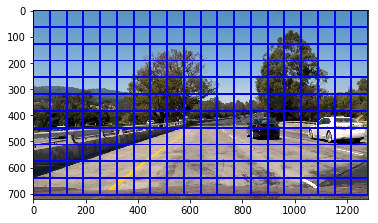

In [246]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
        
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
     # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step)

    
    # Initialize a list to append window positions to
    window_list = []
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


image = cv2.imread('test_images/test1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
                       
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

## Training Classifier with Combined Features

We can test the performance of a classifier by using combined features: HOG, histograms of color, and spatial binning.

In [8]:
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for fname in imgs:
        file_features = []
        # Read in each one by one
        image = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

# Get features for cars and non-cars
car_features = extract_features(cars, cspace='YCrCb', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel='ALL', spatial_feat=True, hist_feat=True, hog_feat=True)
noncar_features = extract_features(non_cars, cspace='YCrCb', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel='ALL', spatial_feat=True, hist_feat=True, hog_feat=True)

# Create feature vectors
y = np.hstack((np.ones(len(car_features)), np.zeros(len(noncar_features))))
X = np.vstack((car_features, noncar_features)).astype(np.float64)

# Fit and apply the scaler to X
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

# Use a linear SVC (support vector classifier)
svc = LinearSVC()
# Train the SVC
svc.fit(X_train, y_train)

print(X_test[0:10].reshape)
print('Test Accuracy of SVC = ', svc.score(X_test, y_test))

print('My SVC predicts: ', svc.predict(X_test[0:10]))
print('For labels: ', y_test[0:10])



<built-in method reshape of numpy.ndarray object at 0x7fd2ed221d50>
Test Accuracy of SVC =  0.994087837838
My SVC predicts:  [ 1.  0.  1.  0.  1.  1.  0.  0.  1.  0.]
For labels:  [ 1.  0.  1.  0.  1.  1.  0.  0.  1.  0.]


## Checkpoint: Save the classifier and scaler

In [9]:
import pickle

dist_pickle = {}
dist_pickle['svc'] = svc
dist_pickle['X_scaler'] = X_scaler
pickle.dump(dist_pickle, open('svc1.p', 'wb'))

In [294]:
import pickle

dist_pickle = pickle.load(open('svc1.p', 'rb'))
svc = dist_pickle['svc']
X_scaler = dist_pickle['X_scaler']

## Testing Sliding Window Approach for Detection

The following cells test the sliding windows method for detection.

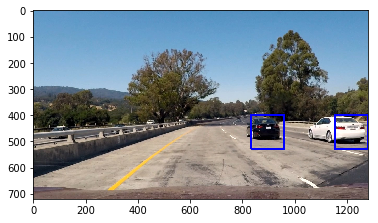

In [248]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows


img = cv2.imread('test_images/test1.jpg')
image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

draw_image = np.copy(image)

color_space = 'YCrCb'
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 656] # Min and max in y to search in slide_window()


windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)

plt.imshow(window_img)

## HOG Subsampling Method for Detection

The following cells show how we can extract HOG features for an entire image and then subsample cells.

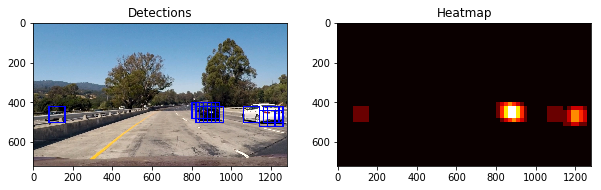

In [254]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)


def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    heatmap = np.zeros_like(img[:,:,0])
    #img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] += 1
                
    return draw_img, heatmap


img = cv2.imread('test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

result, heatmap = find_cars(img, ystart=400, ystop=656, scale=1.25, svc=svc, X_scaler=X_scaler, orient=9, pix_per_cell=8, cell_per_block=2, spatial_size=(32, 32), hist_bins=32)

# Plot the examples
fig = plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(result)
plt.title('Detections')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heatmap')

Cars found: 2


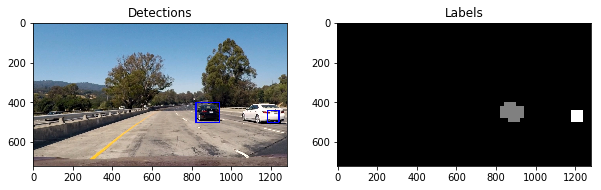

In [297]:
def add_heat(heatmap, bboxes):
    for box in bboxes:
        heatmap[box[0][0]:box[0][1], box[1][0]:box[1][1]] += 1
    return heatmap

def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


from scipy.ndimage.measurements import label


img = cv2.imread('test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

result, heatmap = find_cars(img, ystart=400, ystop=656, scale=1.25, svc=svc, X_scaler=X_scaler, orient=9, pix_per_cell=8, cell_per_block=2, spatial_size=(32, 32), hist_bins=32)


heatmap = apply_threshold(heatmap, 2)
labels = label(heatmap)
print('Cars found: {}'.format(labels[1]))

img_boxes = draw_labeled_bboxes(img, labels)

# Plot the examples
fig = plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(img_boxes)
plt.title('Detections')
plt.subplot(122)
plt.imshow(labels[0], cmap='gray')
plt.title('Labels')



Cars found: 0
Cars found: 2
Cars found: 2
Cars found: 0
Cars found: 1
Cars found: 3


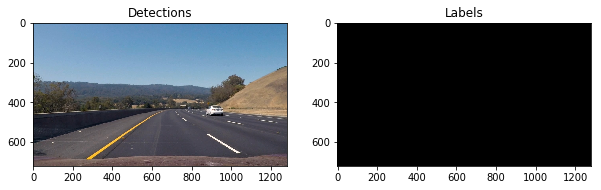

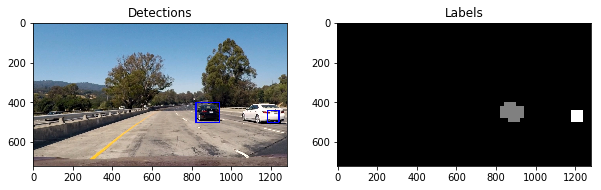

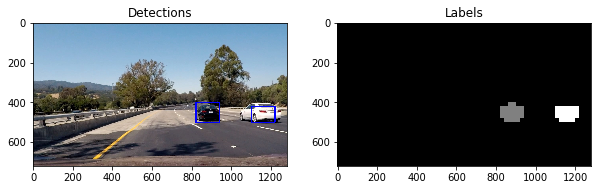

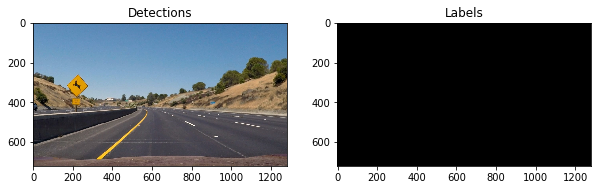

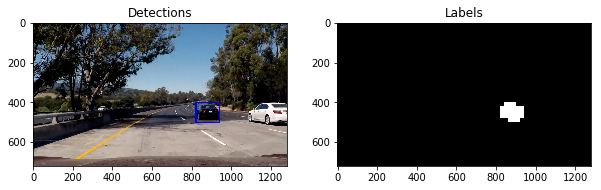

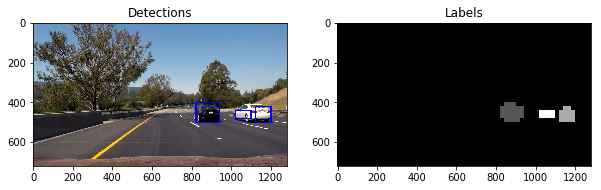

In [298]:
images = glob.glob('test_images/test*.jpg')

for img in images:
    img = cv2.imread(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    result, heatmap = find_cars(img, ystart=400, ystop=656, scale=1.25, svc=svc, X_scaler=X_scaler, orient=9, pix_per_cell=8, cell_per_block=2, spatial_size=(32, 32), hist_bins=32)
    heatmap = apply_threshold(heatmap, 2)
    labels = label(heatmap)
    print('Cars found: {}'.format(labels[1]))

    img_boxes = draw_labeled_bboxes(img, labels)

    # Plot the examples
    fig = plt.figure(figsize=(10,10))
    plt.subplot(121)
    plt.imshow(img_boxes)
    plt.title('Detections')
    plt.subplot(122)
    plt.imshow(labels[0], cmap='gray')
    plt.title('Labels')

    

## Vehicle Detection on Video

In [301]:
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    heatmap = np.zeros_like(img[:,:,0])
    #img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    detections = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                #heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] += 1
                detections.append(((ytop_draw+ystart,ytop_draw+win_draw+ystart), (xbox_left, xbox_left+win_draw)))
                
                
    return detections

In [302]:
class Detections():
    def __init__(self):
        self.detections = []
        self.heatmaps = []
        
    def add_boxes(self, bboxes):
        if len(self.detections) > 10:
            self.detections.pop(0)
        self.detections.append(bboxes)
        
    def get_bboxes(self):
        return [bbox for detection in self.detections for bbox in detection]
    
    
    def add_heatmap(self, heatmap):
        if len(self.heatmaps) > 10:
            self.heatmaps.pop(0)
        self.heatmaps.append(heatmap)
    
    def get_heatmap(self):
        return np.sum(np.array(self.heatmaps), axis=0)
    

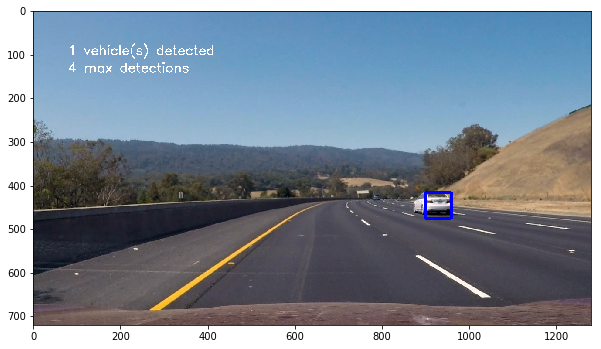

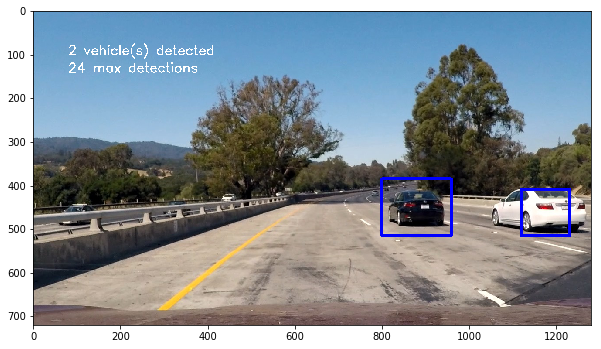

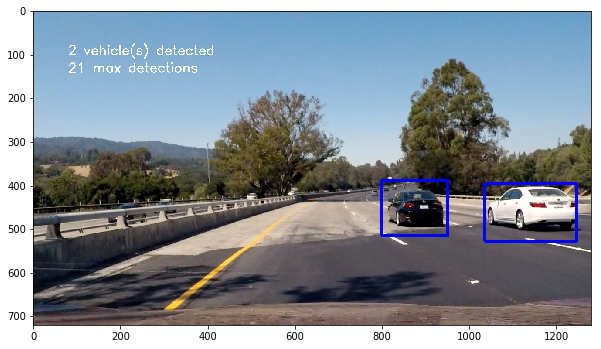

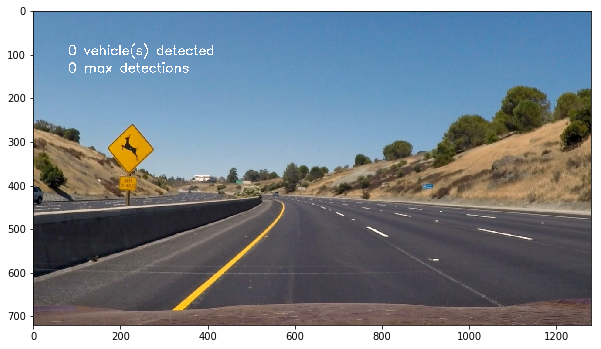

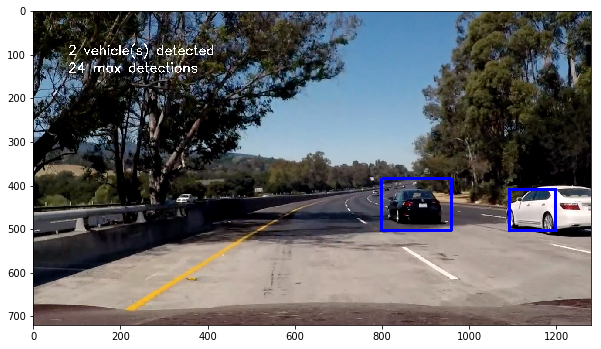

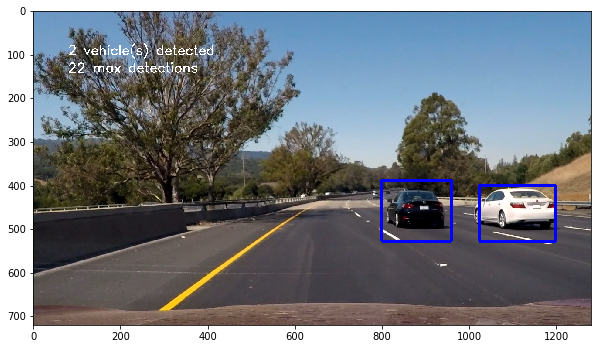

In [322]:
def process_img(img, threshold=25):
    detections = find_cars(img, ystart=336, ystop=536, scale=1.25, svc=svc, X_scaler=X_scaler, orient=9, pix_per_cell=8, cell_per_block=2, spatial_size=(32, 32), hist_bins=32)
    detections.extend(find_cars(img, ystart=336, ystop=656, scale=1.5, svc=svc, X_scaler=X_scaler, orient=9, pix_per_cell=8, cell_per_block=2, spatial_size=(32, 32), hist_bins=32))
    detections.extend(find_cars(img, ystart=360, ystop=656, scale=1.75, svc=svc, X_scaler=X_scaler, orient=9, pix_per_cell=8, cell_per_block=2, spatial_size=(32, 32), hist_bins=32))
    detections.extend(find_cars(img, ystart=400, ystop=656, scale=2, svc=svc, X_scaler=X_scaler, orient=9, pix_per_cell=8, cell_per_block=2, spatial_size=(32, 32), hist_bins=32))
    
    det.add_boxes(detections)
    heatmap = np.zeros_like(img[:,:,0])
    bboxes = det.get_bboxes()
    heatmap = add_heat(heatmap, bboxes)
    heatmap = apply_threshold(heatmap, threshold)
    labels = label(heatmap)
    img_boxes = draw_labeled_bboxes(img, labels)
    cv2.putText(img_boxes, '{} vehicle(s) detected'.format(labels[1]), (80,100), fontFace=16, fontScale=1, color=(255,255,255), thickness = 2)
    cv2.putText(img_boxes, '{} max detections'.format(np.max(heatmap)), (80,140), fontFace=16, fontScale=1, color=(255,255,255), thickness = 2)
    return img_boxes


images = glob.glob('test_images/test*.jpg')
for img in images:
    img = cv2.imread(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    det = Detections()
    result = process_img(img, threshold=3)

    # Plot the examples
    fig = plt.figure(figsize=(10,10))
    plt.imshow(result)
    

In [327]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

det = Detections()

ld_fname = 'project_video.mp4'
out_fname = 'project_output6.mp4'
clip = VideoFileClip(ld_fname)
output = clip.fl_image(process_img)
%time output.write_videofile(out_fname, audio=False)

[MoviePy] >>>> Building video project_output6.mp4
[MoviePy] Writing video project_output6.mp4


100%|█████████▉| 1260/1261 [25:00<00:01,  1.28s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output6.mp4 

CPU times: user 30min 17s, sys: 3.16 s, total: 30min 20s
Wall time: 25min 1s


In [328]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(out_fname))

In [335]:
def save_frame(img):
    global count
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    cv2.imwrite('output_images/frame{}.jpg'.format(count), img)      
    count +=1
    return img

count = 0
det = Detections()

ld_fname = 'project_video.mp4'
out_fname = 'frames.mp4'
clip = VideoFileClip(ld_fname).subclip(8, 9)
output = clip.fl_image(save_frame)
%time output.write_videofile(out_fname, audio=False)

[MoviePy] >>>> Building video frames.mp4
[MoviePy] Writing video frames.mp4


 96%|█████████▌| 25/26 [00:01<00:00, 18.06it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: frames.mp4 

CPU times: user 2.75 s, sys: 52 ms, total: 2.8 s
Wall time: 2.24 s


11


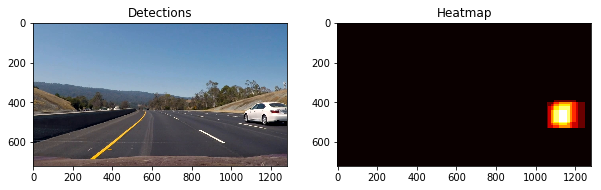

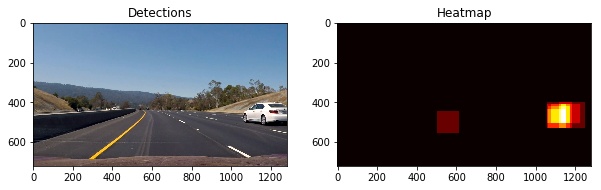

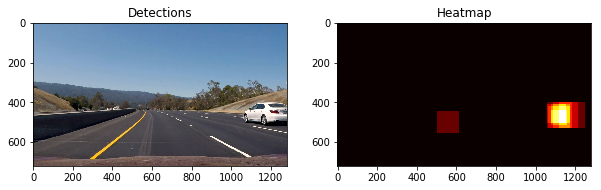

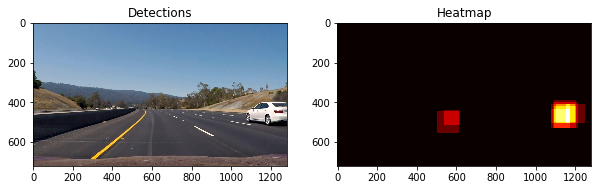

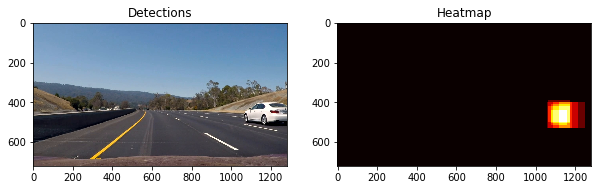

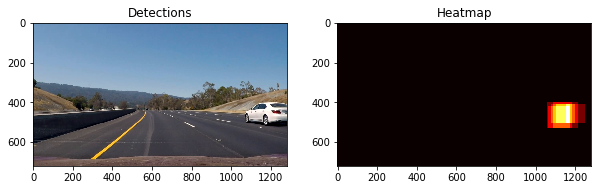

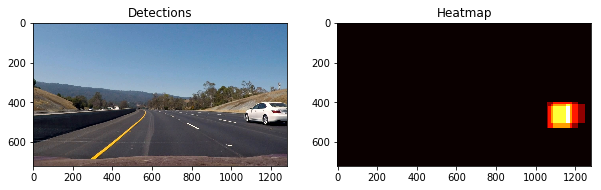

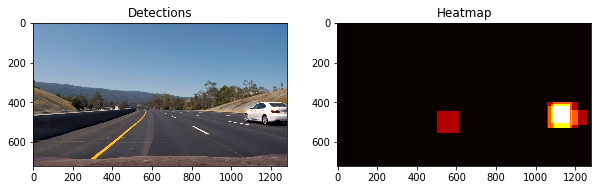

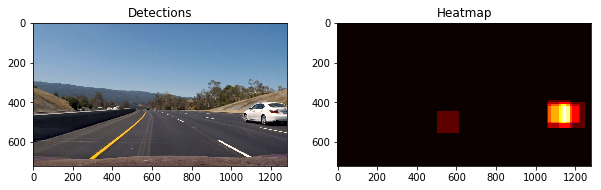

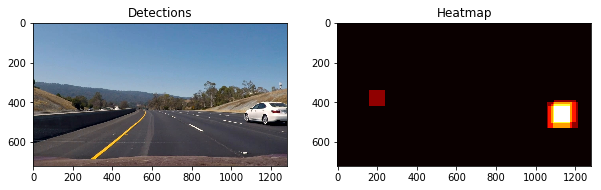

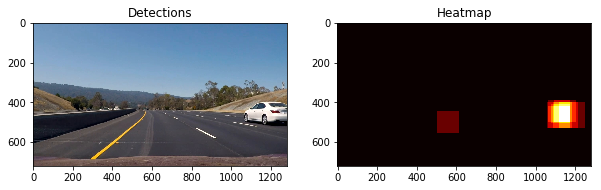

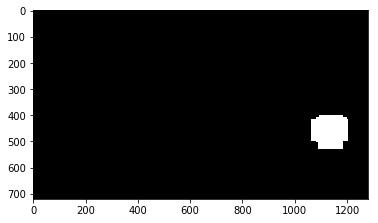

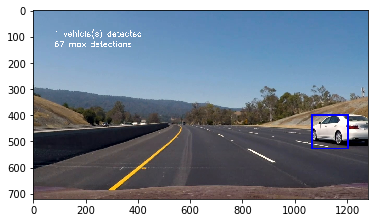

In [347]:
def visualize_detect(img):
    detections = find_cars(img, ystart=336, ystop=536, scale=1.25, svc=svc, X_scaler=X_scaler, orient=9, pix_per_cell=8, cell_per_block=2, spatial_size=(32, 32), hist_bins=32)
    detections.extend(find_cars(img, ystart=336, ystop=656, scale=1.5, svc=svc, X_scaler=X_scaler, orient=9, pix_per_cell=8, cell_per_block=2, spatial_size=(32, 32), hist_bins=32))
    detections.extend(find_cars(img, ystart=360, ystop=656, scale=1.75, svc=svc, X_scaler=X_scaler, orient=9, pix_per_cell=8, cell_per_block=2, spatial_size=(32, 32), hist_bins=32))
    detections.extend(find_cars(img, ystart=400, ystop=656, scale=2, svc=svc, X_scaler=X_scaler, orient=9, pix_per_cell=8, cell_per_block=2, spatial_size=(32, 32), hist_bins=32))
    
    det.add_boxes(detections)
    heatmap = np.zeros_like(img[:,:,0])
    heatmap = add_heat(heatmap, detections)
    return heatmap
    
    
    
det = Detections()

images = glob.glob('output_images/frame1*.jpg')
print(len(images))
for img in images:
    img = cv2.imread(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    heatmap = visualize_detect(img)
    # Plot the examples
    fig = plt.figure(figsize=(10,10))
    plt.subplot(121)
    plt.imshow(img)
    plt.title('Detections')
    plt.subplot(122)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heatmap')
    
heatmap = np.zeros_like(img[:,:,0])
bboxes = det.get_bboxes()
heatmap = add_heat(heatmap, bboxes)
heatmap = apply_threshold(heatmap, 25)
labels = label(heatmap)
img_boxes = draw_labeled_bboxes(img, labels)
cv2.putText(img_boxes, '{} vehicle(s) detected'.format(labels[1]), (80,100), fontFace=16, fontScale=1, color=(255,255,255), thickness = 2)
cv2.putText(img_boxes, '{} max detections'.format(np.max(heatmap)), (80,140), fontFace=16, fontScale=1, color=(255,255,255), thickness = 2)

plt.figure()
plt.imshow(labels[0], cmap='gray')

plt.figure()
plt.imshow(img_boxes)

